<h2>Single Cell Data Processing</h2>

<h3>Table of contents</h3>
<br/>
<a href='#intro'>Introduction</a>
<br/>
<a href='#Imports'>Imports</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#data_processing'>Data processing</a>
<br/>

<a id="intro"></a><h2> Introduction </h2>

This notebook servers as a template for our single-cell rna-seq data processing pipeline. For read alignment pipeline, please refer to https://github.com/Ken-Lau-Lab/STAR_Protocol/blob/master/Single-cell_read_alignment_and_DropEst_library_quantification.ipynb

## Imports

In [8]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import os

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Inline plotting
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Reset random seed
np.random.seed(5)

In [9]:
sc.set_figure_params(dpi=300,dpi_save=300)

<a id="data"></a><h2> Loading data </h2>

We recommend the use of <a href="https://scanpy-tutorials.readthedocs.io/en/latest/index.html">scanpy</a> <a href="https://anndata.readthedocs.io/en/latest/">Anndata</a> objects for loading and processing data. 

In [58]:
ad = sc.read_h5ad('concat_E7.75_8.5.h5ad')

<b>NOTE</b>: Counts are assumed to be raw count. If you have already normalized the data, skip past the `Normalization` section

<a id="data_processing"></a><h2> Data processing </h2>

### Normalization

Normalize the data for molecule count distribution using the `scanpy` interface

In [7]:
sc.pp.normalize_per_cell(ad)

We recommend that the data be log transformed. Note that, some datasets show better signal in the linear scale while others show stronger signal in the log scale.

The function below uses a `pseudocount` of 0.1 instead of 1.

In [8]:
ad.X= np.log2(ad.X + 0.1) - np.log2(0.1)

### Highly variable gene selection

Highly variable gene selection can also be performed using the `scanpy` interface

In [11]:
sc.pp.highly_variable_genes(ad, n_top_genes=4000, flavor='seurat')

### PCA

PCA is the first step in data processing. This representation is necessary to overcome the extensive dropouts that are pervasive in single cell RNA-seq data. 

Rather than use a fixed number of PCs, we recommend the use of components that explain 85% of the variance in the data after highly variable gene selection.

In [12]:
sc.pp.pca(ad,random_state=0,use_highly_variable=True)

In [13]:
pca_projections = ad.obsm['X_pca']

In [14]:
pca_projections.shape

(210, 50)

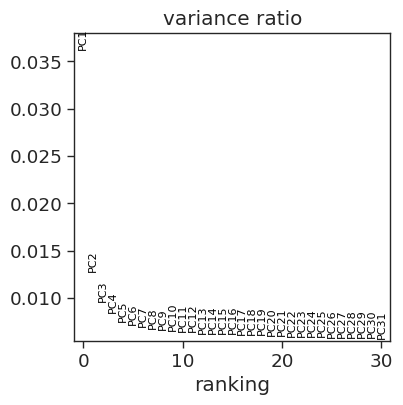

In [15]:
sc.pl.pca_variance_ratio( ad)

### Harmony

Harmony is used for batch correction.

In [16]:
import harmonypy as hm

In [17]:
meta_data = pd.DataFrame(ad.obs['batch'])

In [18]:
vars_use = ['batch']

In [19]:
data_mat = pca_projections[:,:10]

In [20]:
data_mat.shape

(210, 10)

In [21]:
ho = hm.run_harmony(data_mat, meta_data, vars_use,max_iter_harmony=50)

2023-03-03 15:09:01,121 - harmonypy - INFO - Iteration 1 of 50
2023-03-03 15:09:01,138 - harmonypy - INFO - Iteration 2 of 50
2023-03-03 15:09:01,166 - harmonypy - INFO - Iteration 3 of 50
2023-03-03 15:09:01,192 - harmonypy - INFO - Iteration 4 of 50
2023-03-03 15:09:01,216 - harmonypy - INFO - Iteration 5 of 50
2023-03-03 15:09:01,246 - harmonypy - INFO - Converged after 5 iterations


In [22]:
res = pd.DataFrame(ho.Z_corr)
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
#res.to_csv("adj.tsv.gz", sep = "\t", index = False)

In [23]:
ad.obsm['X_pca_harmony'] = res.T.values

### Diffusion maps

Palantir next determines the diffusion maps of the data as an estimate of the low dimensional phenotypic manifold of the data.

In [24]:
# Run diffusion maps
pca_projections = pd.DataFrame(ad.obsm['X_pca_harmony'], index=ad.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=50)

Determing nearest neighbor graph...


/home/yilin/anaconda3/envs/palantir/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The low dimensional embeddeing of the data is estimated based on the eigen  gap using the following function

In [25]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

If you are specifying the number of eigen vectors manually in the above step, please ensure that the specified parameter is > 2

### Visualization

`scanpy` can be used to compute force directed layouts. We recommened the use of the diffusion kernel (see below) for computing force directed layouts
`Force Atlas` package should be installed for this analysis and can be installed using `conda install -c conda-forge fa2`. Note that fa2 is not supported by python3.9

UMAPs are a good alternative to visualize trajectories in addition to force directed layouts.

In [26]:
import harmony
fdl = harmony.plot.force_directed_layout(dm_res['kernel'], ad.obs_names)

100%|███████████████████████████████████████| 500/500 [00:00<00:00, 1503.35it/s]

BarnesHut Approximation  took  0.16  seconds
Repulsion forces  took  0.13  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


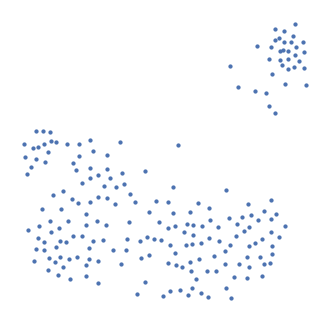

In [27]:
fig, ax = palantir.plot.plot_tsne(fdl)

In [28]:
ad.obsm['X_fdl'] = fdl.values

In [29]:
from scipy import sparse

In [30]:
ad.X = sparse.csr_matrix(ad.X)

In [31]:
imp_df = palantir.utils.run_magic_imputation(ad, dm_res,n_steps=3)

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


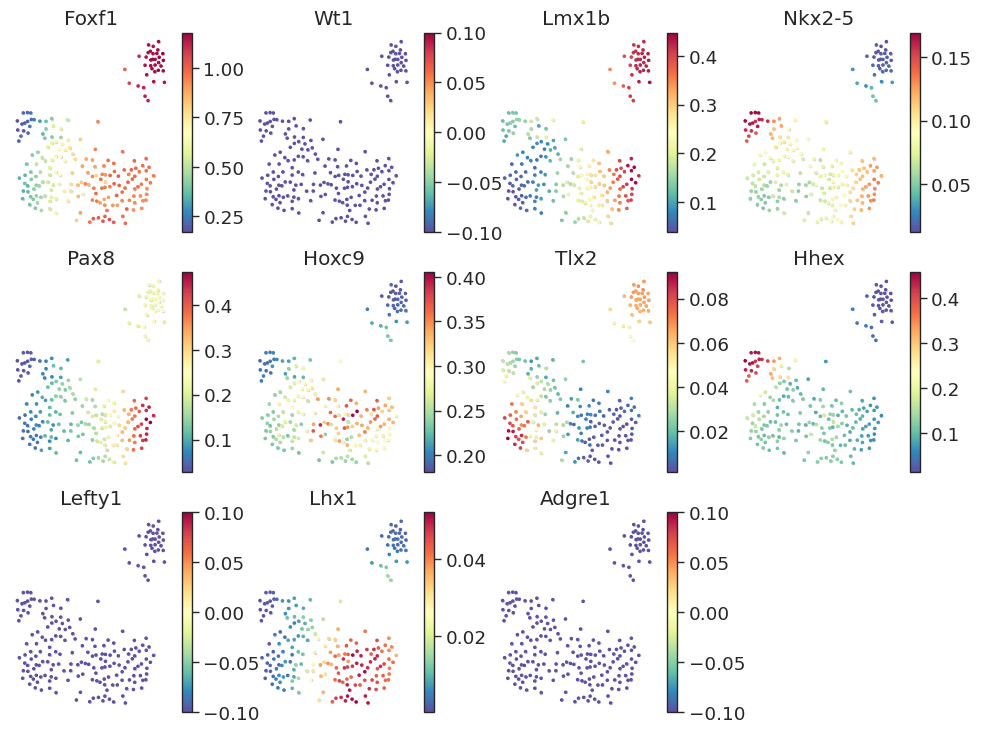

In [33]:
palantir.plot.plot_gene_expression(imp_df, fdl, ['Foxf1','Wt1','Lmx1b','Nkx2-5','Pax8','Hoxc9','Tlx2','Hhex','Lefty1','Lhx1','Adgre1'],plot_scale=True,n_cols=4)
plt.savefig('palantir.png')